## Finetune full BERT model on the processed financial dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import label_binarize

from dotenv import load_dotenv
import os
os.environ["WANDB_DISABLED"] = "true"

from huggingface_hub import login

import evaluate

from datasets import load_dataset

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import logging

from peft import get_peft_model, LoraConfig, TaskType

import time

import torch

load_dotenv()

2025-10-08 05:38:29.613770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759901909.796932      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759901909.847104      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
login(os.getenv('HUGGINGFACE_API_KEY'))

In [4]:
dataset = load_dataset('Jiahao123/FinancialPhraseBank_processed')

README.md:   0%|          | 0.00/547 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/349k [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/45.4k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/46.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3876 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/485 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/485 [00:00<?, ? examples/s]

### Initialize model

In [5]:
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=3)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

### Tokenize the text

In [8]:
def tokenize(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['index', 'label', 'text'],
        num_rows: 3876
    })
    validation: Dataset({
        features: ['index', 'label', 'text'],
        num_rows: 485
    })
    test: Dataset({
        features: ['index', 'label', 'text'],
        num_rows: 485
    })
})

In [10]:
dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

In [11]:
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

### Set up for training

In [15]:
metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # convert the logits to their predicted class
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average='weighted')

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
device

'cuda'

In [13]:
training_args = TrainingArguments(
    output_dir="financial_classifier",
    learning_rate=1e-5,
    logging_steps=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    logging_strategy="steps",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
    report_to=None
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_metrics,
)

In [17]:
# train model
start_time = time.time()

trainer.train()

end_time = time.time()
print(f"Training took {end_time - start_time} seconds.")

Epoch,Training Loss,Validation Loss,F1
1,0.600900,0.597937,0.696121
2,0.285600,0.383578,0.868169
3,0.241000,0.466502,0.845715
4,0.202200,0.510133,0.862002
5,0.136100,0.590658,0.858640
6,0.103200,0.714399,0.839303
7,0.077500,0.736900,0.865114
8,0.022100,0.789227,0.859096
9,0.027800,0.870917,0.835201
10,0.040500,0.864063,0.844921


Training took 2543.7767782211304 seconds.


We can see that the model overfitted on the data. Training of the model took 2543 seconds.

In [18]:
trainer.push_to_hub("financial-sentiment-BERT")

Uploading...:   0%|          | 0.00/433M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Jiahao123/financial_classifier/commit/ce7f7830ec084514e630c1f0818288fedbe10820', commit_message='financial-sentiment-BERT', commit_description='', oid='ce7f7830ec084514e630c1f0818288fedbe10820', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Jiahao123/financial_classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='Jiahao123/financial_classifier'), pr_revision=None, pr_num=None)

In [26]:
tokenizer.push_to_hub("Jiahao123/financial_classifier")

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Jiahao123/financial_classifier/commit/39bbbc6ca5017b5f207c4ad83ccb23dd1a8c4dcd', commit_message='Upload tokenizer', commit_description='', oid='39bbbc6ca5017b5f207c4ad83ccb23dd1a8c4dcd', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Jiahao123/financial_classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='Jiahao123/financial_classifier'), pr_revision=None, pr_num=None)

In [28]:
trainer.evaluate(dataset['validation'])

{'eval_loss': 0.3835775852203369,
 'eval_model_preparation_time': 0.0028,
 'eval_f1': 0.8681688858231823,
 'eval_runtime': 7.3408,
 'eval_samples_per_second': 66.069,
 'eval_steps_per_second': 4.223}

### Evaluate model performance

In [17]:
trainer.evaluate(dataset['test'])

{'eval_loss': 0.584624171257019,
 'eval_model_preparation_time': 0.0027,
 'eval_f1': 0.8146371060999287,
 'eval_runtime': 7.7512,
 'eval_samples_per_second': 62.571,
 'eval_steps_per_second': 3.999}

In [18]:
predictions = trainer.predict(dataset["test"])

In [19]:
logits = predictions.predictions
labels = predictions.label_ids
probabilities = torch.softmax(torch.tensor(logits), dim=1).numpy()
preds = np.argmax(logits, axis=1)

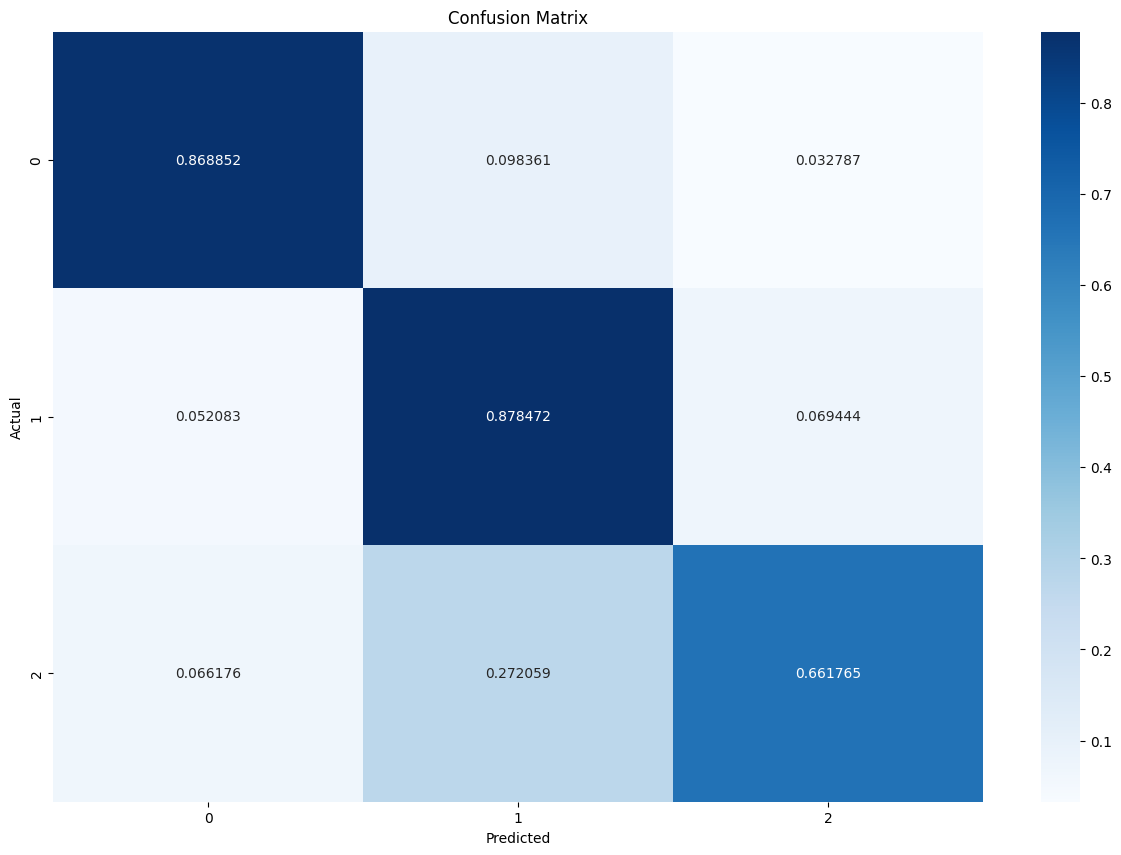

In [20]:
# confusion matrix
cm = confusion_matrix(labels, preds, normalize='true')
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='2f', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We can see that the model seems to perform well for classes 0 and 1, and does poorly for class 2.

About 86% of negative sentiment were correctly predicted as negative, 87% of neutral sentiment were correctly predicted as neutral, while only 66% of positive news were correctly predicted as positive.

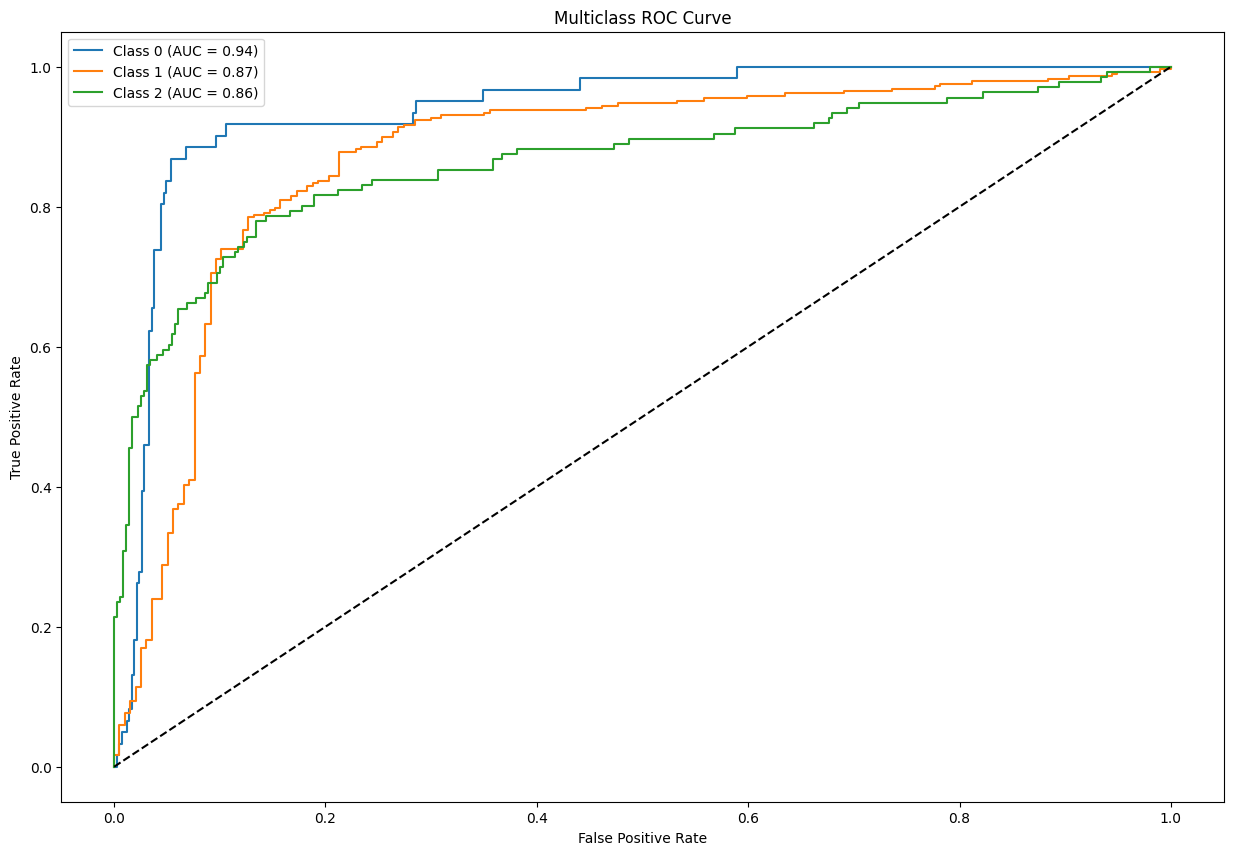

In [21]:
# roc curve for all 3 classes
# one vs all ROC curve
labels_onehot = label_binarize(labels, classes=[0, 1, 2])

plt.figure(figsize=(15, 10))
for i in range(3):
    fpr, tpr, _ = roc_curve(labels_onehot[:, i], probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend()
plt.show()

Model seems to be able to distinguish class 0 the best

In [22]:
report = classification_report(labels, preds)
print(report)

              precision    recall  f1-score   support

           0       0.69      0.87      0.77        61
           1       0.85      0.88      0.87       288
           2       0.80      0.66      0.73       136

    accuracy                           0.82       485
   macro avg       0.78      0.80      0.79       485
weighted avg       0.82      0.82      0.81       485



### Analysis on texts that model predicted as neutral but is actually positive

For the test set

In [25]:
mask = (preds == 1) & (labels == 2)
indices = np.where(mask)[0]

In [26]:
indices

array([  1,   3,  14,  18,  60,  73,  81, 101, 102, 103, 104, 119, 120,
       154, 159, 162, 184, 200, 220, 222, 286, 287, 302, 314, 336, 340,
       355, 358, 381, 402, 408, 418, 429, 433, 443, 469, 473])

In [79]:
wrong_preds = dataset['test'].select(indices)
wrong_probs = probabilities[indices]
wrong_probs_df = pd.DataFrame(wrong_probs, columns=['prob_neg', 'prob_neu', 'prob_pos'])

In [80]:
wrong_preds = wrong_preds.select_columns(['label', 'text'])

In [81]:
wrong_preds

Dataset({
    features: ['label', 'text'],
    num_rows: 37
})

In [82]:
wrong_preds_df = wrong_preds.to_pandas()
wrong_preds_df = pd.concat([wrong_preds_df, wrong_probs_df], axis = 1)

In [84]:
pd.set_option('display.max_colwidth', None)
wrong_preds_df

,label,text,prob_neg,prob_neu,prob_pos
0,2,"Under a memorandum of understanding MoU the parties will collaborate in preparing and implementing joint projects in the fields of combined power and heat generation , environmental protection and energy efficient technologies .",0.016506,0.667894,0.315600
1,2,"Ixonos estimates that it will hire 20 specialists in mechanical engineering , electronics design , and R&D for its new unit in Jyvaeskylae by the end of 2009 .",0.004312,0.982849,0.012839
2,2,The concept enables a commercially affordable way to manufacture high-quality TCO coated glass for the solar industry .,0.007408,0.921826,0.070766
3,2,"Finnish financial solutions developer Basware Corporation ( OMX Helsinki BAS1V ) said on Tuesday ( 23 September ) that it will deliver a complete Invoice Automation solution to a large US engineering , construction and technical services organization .",0.010330,0.883784,0.105887
4,2,"It currently employs about 750 people and expects headcount to reach 1,000 by end of 2007 .",0.009398,0.972008,0.018594
5,2,About Nokia Nokia is a pioneer in mobile telecommunications and the world 's leading maker of mobile devices .,0.015296,0.755066,0.229638
6,2,Certain shareholders have irrevocably agreed to vote in favor of the bond issue .,0.007583,0.979941,0.012476
7,2,"In the Asia-Pacific region , Visa Wave is available in Malaysia , Taiwan and South Korea and will be expanded to Japan and Southeast Asia this year , Jung added .",0.004940,0.969296,0.025764
8,2,The contract was signed in August with Papua New Guinea-based Lihir Gold Ltd ASX : LGL .,0.016079,0.789561,0.194360
9,2,"The sale , which will result in a gain of some EUR 60 million in the second quarter of 2010 for Oriola-KD , supports the Finnish company 's strategy to focus on pharmaceutical wholesale and retail operations .",0.008937,0.906712,0.084352


We can see that there are some pieces of news that could have various interpretations of whether it should be positive or neutral.

For example, the sentence "Airbus has 100 firm orders for the A350 and 89 nonbinding commitments ." does not seem to be positive news for me. Perhaps if there was more context, the model may be able to predict the sentiment more accurately.



However, there are also other sentences that seem fairly obvious that they are positive sentiment, but model classifies it wrongly with high confidence.

For example, the sentence "The company expects its net sales in the first half of 2008 to reach the previous year 's level ." should be regarded as positive news, because the company is earning much more money than the previous year. However, it is predicted as neutral with a probability of 0.955171, signifying wrong prediction.